# Challenge 1: The banknote-authentication data set problem

We will perform a nearly realistic analysis of the data set bank note authentication that can be downloaded from https://archive-beta.ics.uci.edu/dataset/267/banknote+authentication

## Data set description

Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.
These features are:
1. variance of Wavelet Transformed image (continuous)
2. skewness of Wavelet Transformed image (continuous)
3. curtosis of Wavelet Transformed image (continuous)
4. entropy of image (continuous)
5. class (integer)

## Task description
We have a binary classification problem. The assignment can be divided in several parts:
    
    1. Load the data and pretreatment.
    2. Data exploring by Unsupervised Learning techniques.
    3. Construction of several models of Supervised Learning.

In [1]:
#@title [Libraries loading]
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn import preprocessing
from numpy import linalg as LA
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

from scipy.spatial.distance import euclidean
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

randomstate = 64

# 1. Data pretreatment -------------------------------------------------------------------

***Load the data and look at it: It is needed some kind of scaling? Why? Are the data points sorted in the original data set? Can it generate problems? How can this be solved?***

In [ ]:
#@title [Data loading]
FFILE = './data_banknote_authentication.txt'
if os.path.isfile(FFILE):
    print("File already exists")
    if os.access(FFILE, os.R_OK):
        print ("File is readable")
    else:
        print ("File is not readable, removing it and downloading again")
        !rm FFILE
        !wget "https://archive.ics.uci.edu/static/public/267/banknote+authentication.zip"
        !unzip "banknote+authentication"
else:
    print("Either the file is missing or not readable, download it")
    !wget "https://archive.ics.uci.edu/static/public/267/banknote+authentication.zip"
    !unzip "banknote+authentication"

In [3]:
# Load the dataset using Pandas
data = pd.read_csv('data_banknote_authentication.txt', sep=',', names=['Variance WT', 'Skewness WT', 'Curtosis' , 'Entropy', 'Class'])
print(data.head()) # --> data is ordered by class

# Shuffling the database so that classes are not already grouped together
data = data.sample(frac=1, random_state=randomstate)
print(data.head())

   Variance WT  Skewness WT  Curtosis  Entropy  Class
0      3.62160       8.6661   -2.8073 -0.44699      0
1      4.54590       8.1674   -2.4586 -1.46210      0
2      3.86600      -2.6383    1.9242  0.10645      0
3      3.45660       9.5228   -4.0112 -3.59440      0
4      0.32924      -4.4552    4.5718 -0.98880      0
      Variance WT  Skewness WT  Curtosis   Entropy  Class
800       -2.0631    -1.514700    1.2190  0.445240      1
272        4.4072    -0.070365    2.0416  1.131900      0
1339       1.5514     3.801300   -4.9143 -3.748300      1
113        4.2188     6.816200   -1.2804  0.760760      0
911        2.0310     1.852000   -3.0121  0.003003      1


In [4]:
# Transform the data to use it as numpy arrays.
features = data.iloc[:,:-1].values
labels = data.iloc[:,4].values
print(f"Dataset size: ", features.shape)
N = features.shape[0]  # Number of data points
nc = features.shape[1]  # Number of features/components
print(f"Number of features: ", nc)
print(f"Number of classes: ", np.unique(labels))
print(f"Features overview")
print(features)

Dataset size:  (1372, 4)
Number of features:  4
Number of classes:  [0 1]
Features overview
[[-2.0631   -1.5147    1.219     0.44524 ]
 [ 4.4072   -0.070365  2.0416    1.1319  ]
 [ 1.5514    3.8013   -4.9143   -3.7483  ]
 ...
 [ 0.9297   -3.7971    4.6429   -0.2957  ]
 [-3.0866   -6.6362   10.5405   -0.89182 ]
 [ 0.77124   9.0862   -1.2281   -1.4996  ]]


In [5]:
# standardization via standar scale
from sklearn.preprocessing import StandardScaler

# 2. Unsupervised Learning -------------------------------------------------------------------

***Use PCA and plot the two first components colouring according with the class. Are the classes linearly separable in this projection? What happens when I applied k-means with two classes in this space? And if I use all the coordinates? Try also t-SNE for projection and DBSCAN for the clustering and comment on the results.***

## Dimensionality reduction with PCA

PCA (Principal Component Analysis) is a dimensionality reduction technique that transforms data into a new coordinate system where the greatest variance lies along the first principal component, the second greatest along the second component, and so forth. It achieves this by finding the eigenvectors and eigenvalues of the data covariance matrix, allowing for the retention of most of the variability in fewer dimensions.

In [6]:
# Labels are already encoded as numbers
y = labels.reshape(-1, 1)

Scaling our data is not mandatory, however it is useful in cases where our features have very different orders of magnitude; in such cases, scaling helps with PCA computation.

Here, we choose to standardize via a standard scaler.

In [7]:
# Applying the standard scaler to each column; this ensures that the data is centered
scaler = StandardScaler()
X_ctr = scaler.fit_transform(features)

print("Scaled dataset")
print(X_ctr)

Scaled dataset
[[-0.87863323 -0.58583728 -0.04145963  0.77938274]
 [ 1.39825732 -0.33965392  0.1494671   1.10632519]
 [ 0.39330484  0.32026189 -1.46500802 -1.21730591]
 ...
 [ 0.17452938 -0.97486676  0.75323284  0.42659572]
 [-1.23880161 -1.4587844   2.1220749   0.14276248]
 [ 0.1187675   1.22106014 -0.60943531 -0.14662248]]


#### Model Assessment: choose the number of PCs to keep
We now need to choose which PCs are useful to explain our model. This means that by removing the PCs which are not, we consequentenly reduce the dimensionality and thus simplify the problem.

We start with the assumption that 2 components are enough, for now. Later, we will try to see if this is actually a valid assumption.



In [8]:
# Performing Principal Component Analysis (PCA) using sklearn
pca = PCA(n_components=2, random_state=randomstate)

# Fitting the PCA model to the scaled data
pca.fit(X_ctr)

# Transforming the original data to the principal components
projection = pca.transform(X_ctr)

# Extracting eigenvalues
eigenvalues = pca.explained_variance_
print(f"Eigenvalues: ", eigenvalues)
print("PCA output:")
print(projection)

Eigenvalues:  [2.18149408 1.29409812]
PCA output:
[[ 0.87353721  0.13145989]
 [ 0.39499003 -1.75290723]
 [-1.67787103  0.26873719]
 ...
 [ 1.20873901 -0.33650188]
 [ 2.59704176  1.09620671]
 [-1.24113632 -0.02842249]]


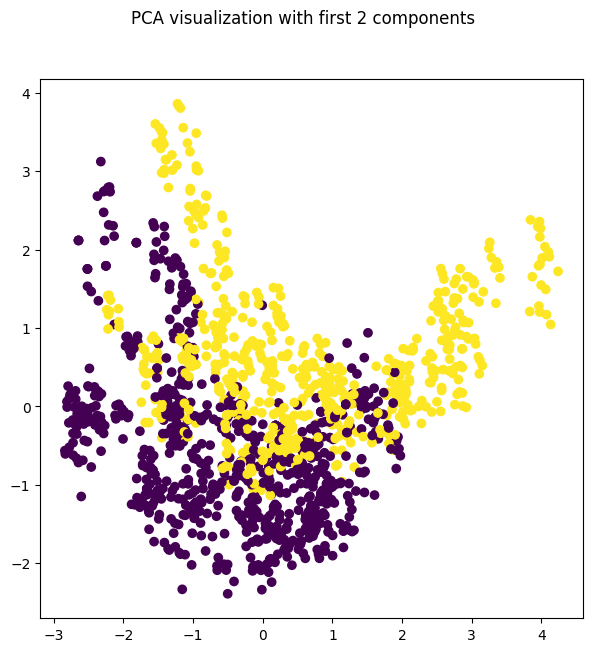

In [9]:
#@title [Plot]
# Creating subplots
fig = plt.figure(figsize=(7,7))
fig.suptitle('PCA visualization with first 2 components')

# Plotting the 2D representation of the dataset using the first two Principal Components
ax = fig.add_subplot()
ax.scatter(projection[:, 0], projection[:, 1], c=y)

plt.show()

The data is definitely not linearly separable.

## Clustering with K-means

Flat clustering algorithm whose goal is to minimize the intracluster distance while maximizing the intercluster distance.

We can compute the k-means clustering using two types of initialization:
    
  1. Random initialization: cluster centroids are initialized picking random points from the dataset;
  
  2. k-means++: choose first cluster center at random, then choose new cluster centers in such a way that they are far from existing centers. We choose this method for our analysis.

In [10]:
#@title [Code]
def k_means_internal(k, X, init):

    N = X.shape[0]  # number of points
    nc = X.shape[1]  # number of coordinates
    ll = np.arange(k)
    z = np.zeros(N, dtype='int')  # cluster number assigned to each data point
    cent = np.zeros([k, nc])  # coordinates of the cluster centers

    # k-means++
    if init == '++':
        b = np.random.choice(N, 1, replace=False)  # choose the first cluster center at random
        cent[0, :] = X[b, :]
        nchosen = 1  # number of cluster centers already set

        while nchosen < k:
            dist = cdist(cent[:nchosen, :], X)  # distance of each point from the cluster centers
            dmin = np.min(dist, axis=0)  # min distance between point and cluster centers
            prob = dmin**2
            prob = prob / np.sum(prob)

            # choose next center according to the computed prob
            b = np.random.choice(N, 1, replace=False, p=prob)
            cent[nchosen, :] = X[b, :]
            nchosen += 1

    # random initialization
    else:
        b = np.random.choice(N, k, replace=False)  # choose the k centers randomly
        for i in ll:
            cent[i, :] = X[b[i], :]

    dist = cdist(cent, X)  # distance of each point from cluster centers
    z_new = np.argmin(dist, axis=0)  # assign each point to cluster with the closest center
    dmin = np.min(dist, axis=0)
    niter = 0
    L = np.sum(dmin**2)  # loss function evaluation

    while (z_new != z).any():  # until a stable configuration is reached
        z = np.copy(z_new)

        for i in range(k):
            cent[i, :] = np.average(X[z == i, :], axis=0)  # compute cluster centroids

        dist = cdist(cent, X)  # update distances from cluster centers
        z_new = np.argmin(dist, axis=0)  # find cluster with the minimum centroid distance
        dmin = np.min(dist, axis=0)
        L = np.sum(dmin**2)  # loss function evaluation
        niter += 1

    return z_new, L, niter


def k_means(k, X, init='++', n_init=20):

    lmin = float('inf')  # Initialize with a large value
    labels_opt = None

    for i in range(n_init):
        # Run k-means for each initialization
        labels, loss, niter = k_means_internal(k, X, init=init)

        # Check if the current iteration has a lower loss
        if loss < lmin:
            lmin = loss
            labels_opt = labels

    return labels_opt, lmin

### k-means with a fixed number of clusters, k = 2

***What happens when I applied k-means with two classes in this space?***

In [11]:
kmeans_labels, l_kmeans = k_means(2, projection, init='++', n_init=20)
#print(l_kmeans)

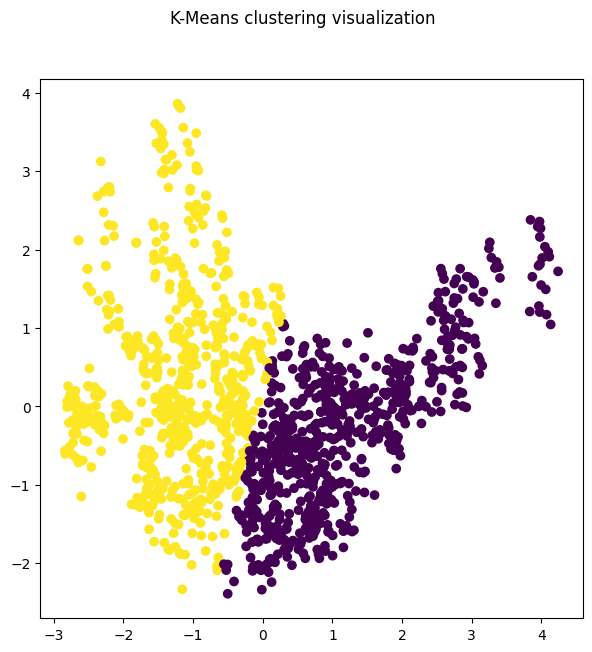

In [40]:
#@title [Plot]
# Creating subplots
fig = plt.figure(figsize=(7,7))
fig.suptitle('K-Means clustering visualization')

# 2D
ax = fig.add_subplot(1, 1, 1)
ax.scatter(projection[:, 0], projection[:, 1], c=kmeans_labels)

plt.show()

Cluster validation

In [13]:
# Compute the normalized mutual information between the predicted and the ground truth classification
print(f"Normalized mutual information: ", normalized_mutual_info_score(kmeans_labels, y.flatten()))

Normalized mutual information:  0.010764273647205076


 ***And if I use all the coordinates?***

 --> Recalculating PCA with all 4 features

In [14]:
pca = PCA(n_components=4, random_state=randomstate)

pca.fit(X_ctr)
new_projection = pca.transform(X_ctr)

cumulative_variance = np.zeros(nc)
for i in range(nc):
    cumulative_variance[i] = np.sum(pca.explained_variance_ratio_[:i+1])

eigenvalues = pca.explained_variance_
components = np.arange(nc) + 1

print(f"Eigenvalues: ", eigenvalues)
print("PCA output:")
print(new_projection)

Eigenvalues:  [2.18149408 1.29409812 0.35163873 0.17568664]
PCA output:
[[ 0.87353721  0.13145989 -0.95274953 -0.19046626]
 [ 0.39499003 -1.75290723  0.29315627  0.04628906]
 [-1.67787103  0.26873719  0.18657675 -0.98135458]
 ...
 [ 1.20873901 -0.33650188  0.3453803  -0.19130673]
 [ 2.59704176  1.09620671  0.4171758   0.25677545]
 [-1.24113632 -0.02842249 -0.29224021  0.52093339]]


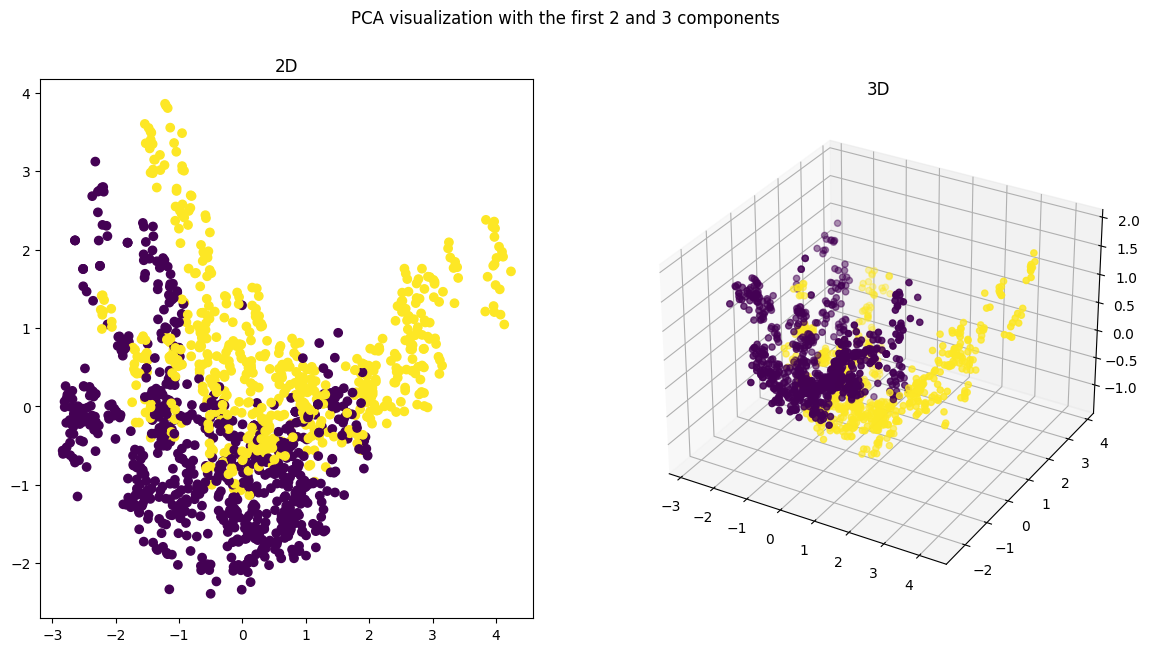

In [41]:
#@title [Plot]
# Creating subplots
fig = plt.figure(figsize=(14,7))
fig.suptitle('PCA visualization with the first 2 and 3 components')

# Plotting the 2D representation of the dataset using the first two Principal Components
ax = fig.add_subplot(1, 2, 1)
ax.scatter(new_projection[:, 0], new_projection[:, 1], c=y)
ax.set_title('2D')

# Plotting the 3D representation of the dataset using the first three Principal Components
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(new_projection[:,0], new_projection[:,1], new_projection[:,2], c=y)
ax.set_title('3D')

plt.show()

In [16]:
kmeans_labels, l_kmeans = k_means(2, new_projection, init='++', n_init=20)
# print(l_kmeans)

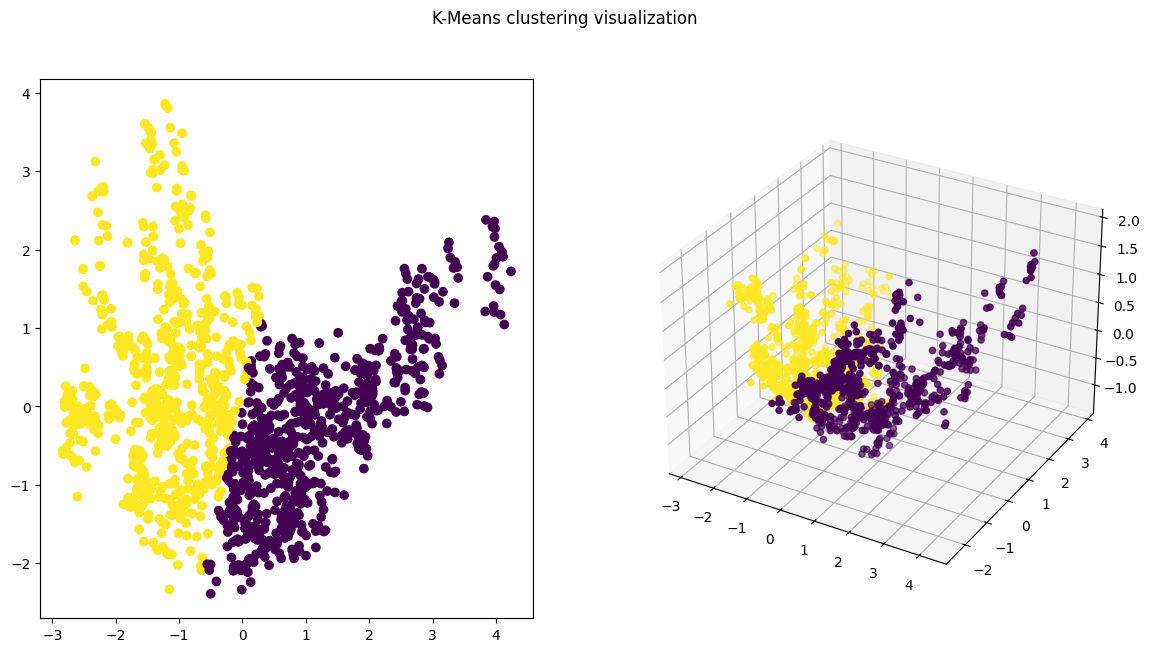

In [17]:
#@title [Plot]
# Creating subplots
fig = plt.figure(figsize=(14,7))
fig.suptitle('K-Means clustering visualization')

# 2D
ax = fig.add_subplot(1, 2, 1)
ax.scatter(projection[:, 0], projection[:, 1], c=kmeans_labels)

# 3D
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(new_projection[:,0], new_projection[:,1], new_projection[:,2], c=kmeans_labels)

plt.show()

In [18]:
# Compute the normalized mutual information between the predicted and the ground truth classification
print(f"Normalized mutual information: ", normalized_mutual_info_score(kmeans_labels, y.flatten()))

Normalized mutual information:  0.010995258562412695


We can clearly see that using all four components does not significantly improve our clustering accuracy; we manage to get an acceptable result with just the first two Principal Components.

*We also do not see a significant improvement in terms of normalized mutual information: .010995 vs .010764*

This observation can be formalized by calculating which are the most relevant features:

1. Proportion of variance explained: given eigenvalues $\lambda_i$ of the covariance matrix and a threshold $t\in [0, 1]$, choose $d$ s.t. the ratio $\chi_d = \frac{\sum_{i=1}^d \lambda_i}{\sum_{i=1}^D \lambda_i} > t$

2. Check the existence of a gap in the spectrum of the covariance matrix.

This translates to keeping those eigenvalues (and so those features) that "explain" the most variability, given the threshold t.

In [19]:
# @title [Code]
# Determine the number of components based on different explained variance thresholds.
for threshold in [0.8, 0.85, 0.9, 0.95, 0.97, 0.99, 0.999]:
    # Find the index where cumulative variance exceeds the threshold
    num_components = np.argmax(cumulative_variance - threshold > 0.) + 1

    # Print the threshold and the corresponding number of components
    print(f"Explained Variance Threshold: {threshold}, Number of Components: {num_components}")

Explained Variance Threshold: 0.8, Number of Components: 2
Explained Variance Threshold: 0.85, Number of Components: 2
Explained Variance Threshold: 0.9, Number of Components: 3
Explained Variance Threshold: 0.95, Number of Components: 3
Explained Variance Threshold: 0.97, Number of Components: 4
Explained Variance Threshold: 0.99, Number of Components: 4
Explained Variance Threshold: 0.999, Number of Components: 4


We can see that with just the first two PCs we already manage decent results

## Dimensionality reduction with t-SNE

T-SNE (t-distributed Stochastic Neighbor Embedding) is a technique for dimensionality reduction and visualization that focuses on preserving local similarities between data points. It models high-dimensional data as probability distributions in low-dimensional space, minimizing the Kullback-Leibler divergence between them. T-SNE iteratively moves points to better represent neighborhood relationships, emphasizing clusters and structure in the data.

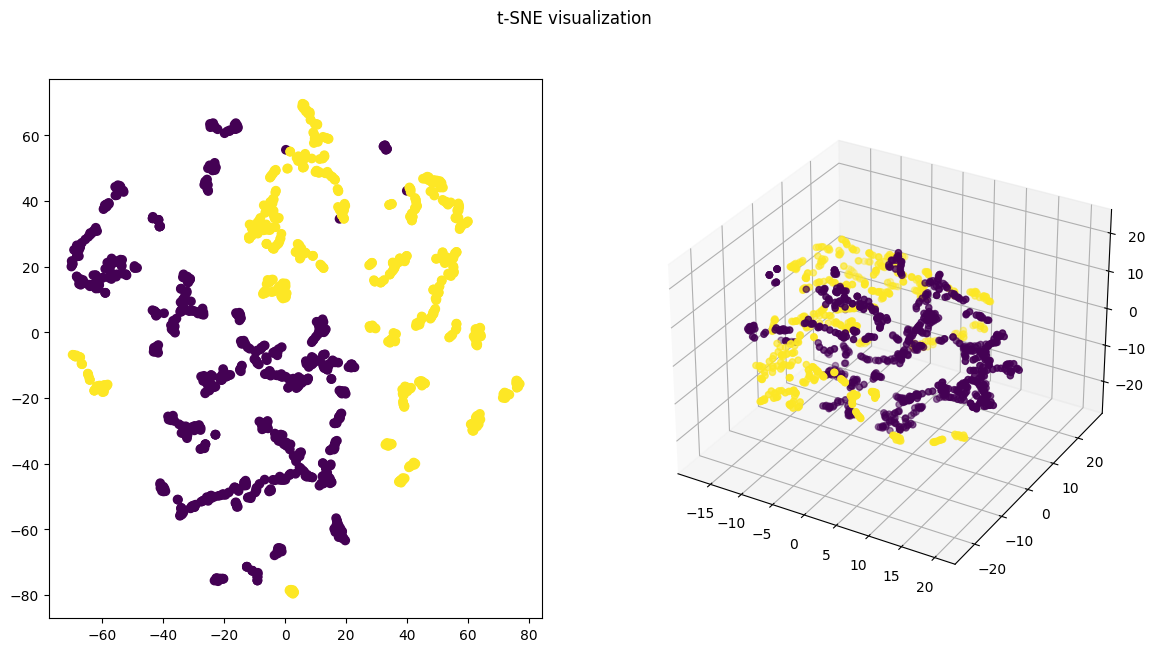

In [20]:
# @title [Plot]
# Use t-SNE to embed high-dimensional data into 2D and 3D spaces for visualization

# Embed the data into 2D and 3D using t-SNE
X_2d = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10, random_state=randomstate).fit_transform(X_ctr)
X_3d = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=10, random_state=randomstate).fit_transform(X_ctr)

# Create a scatter plot of the embedded data, colored by ground truth labels
fig = plt.figure(figsize=(14,7))
fig.suptitle('t-SNE visualization')

ax = fig.add_subplot(1, 2, 1)
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=y)

plt.show()

## Clustering with DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that groups points based on their density. It identifies core points surrounded by a minimum number of neighbors within a specified radius (eps). Points close to core points are considered part of the same cluster, while points not meeting density requirements are classified as noise or outliers.

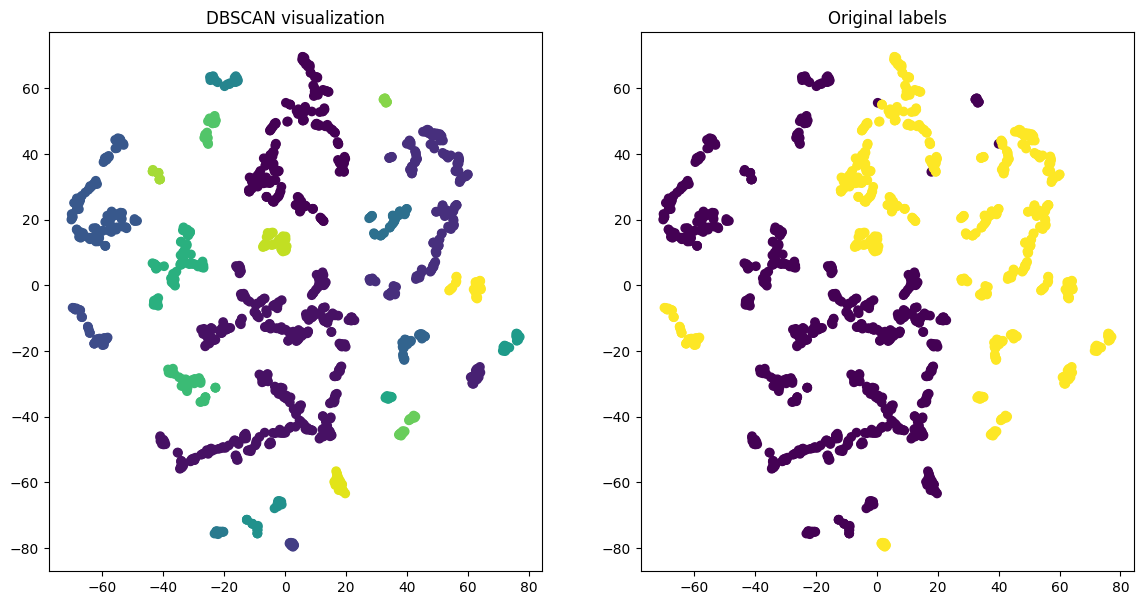

In [21]:
# @title [Plot]
# Apply DBSCAN clustering algorithm to the scaled data
dbscan = DBSCAN(eps=8, min_samples=10).fit(X_2d)

fig = plt.figure(figsize=(14,7))

ax = fig.add_subplot(1, 2, 1)
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=dbscan.labels_)
ax.set_title('DBSCAN visualization')

ax = fig.add_subplot(1, 2, 2)
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y)
ax.set_title('Original labels')

plt.show()

In [22]:
# Compute the normalized mutual information between the predicted and the ground truth classification
print(f"Normalized mutual information: ", normalized_mutual_info_score(dbscan.labels_, y.flatten()))

Normalized mutual information:  0.4242829526346505


DBSCAN, while visually creating more clusters, has a much better normalized mutual information than k-means. This means that DBSCAN managed to at least better identify the two main original clusters.

# 3. Supervised Learning -------------------------------------------------------------------

***Generate a subset of the data of 372 elements that would be saved as test set. With the rest of the data generate the following models: Logistic Regression, Decision tree (use the ID3 algorithm), Naive Bayesian and k-NN.***

***Investigate the effect of regularization (when possible) and use cross validation for setting the hyper-parameters when needed.***

***Compare the performances in terms of accuracy, precision, recall and F1-score on the test set. Comment these results at the light of those obtained from the Unsupervised Learning analysis. Could you propose a way to improve these results?***


In [23]:
# Dataset splitting
data_train = data.iloc[:1000,:]
data_test  = data.iloc[1000:,:]

X_train  = data_train.drop('Class', axis=1).values
X_test   = data_test.drop('Class', axis=1).values
y_train  = data_train['Class'].values
y_test   = data_test['Class'].values

##Regularized Logistic Regression
*with k-fold cross validation*

We want to perform Logistic regression with regularization; to choose the best hyperparameter for the regularization strength, we tune it using k-fold cross validation.

In [24]:
#@title [Code]
def kfcv_logistic(train_data, k, regr_strength, penalty):
    if penalty not in ["l1", "l2", "elasticnet"]:
        penalty = "elasticnet"

    X = train_data.sample(frac=1, random_state=randomstate).reset_index(drop=True) # shuffle the dataframe
    fold_size = int(len(X) / k) # size of each fold
    scores = [] # list to store the scores of each fold

    for current_fold in range(k):
        # split the dataset into training and validation set
        validation_set = X[current_fold*fold_size:(current_fold+1)*fold_size]
        training_set = X.drop(validation_set.index)
        lr_model = LogisticRegression(solver="saga", random_state=randomstate, penalty=penalty, C=regr_strength, l1_ratio=0.5).fit(training_set.drop('Class', axis=1), training_set['Class'])
        score = lr_model.score(validation_set.drop('Class', axis=1), validation_set['Class']) # score is the accuracy
        scores.append(score)

    return np.mean(scores)

In [25]:
k = 5

In [26]:
#@title [Code]
for penalty in ["l1", "l2", "elasticnet"]:
    print(f"Performing k-fold cross validation for {penalty}-regularized Logistic Regression")
    logistic_score = 0
    best_regr_strength = 0

    # trying a range of hyperparameters
    for regr_strength in np.arange(0.1, 1.5, 0.1):
        score = kfcv_logistic(data_train, k, regr_strength, penalty)
        print(" "*100, end='\r') # clear the line
        print(f"regr_strength value: {regr_strength} - current score: {score:.2f}", end='\r')
        if score > logistic_score:
            logistic_score = score
            best_regr_strength = regr_strength

    # print the best score
    print(f"Best score: {logistic_score} with hyperparameter = {best_regr_strength}")

Performing k-fold cross validation for l1-regularized Logistic Regression
Best score: 0.99 with hyperparameter = 0.30000000000000004
Performing k-fold cross validation for l2-regularized Logistic Regression
Best score: 0.991 with hyperparameter = 0.4
Performing k-fold cross validation for elasticnet-regularized Logistic Regression
Best score: 0.991 with hyperparameter = 0.4


We can see that L2 and Elastic Net regularization are on par in terms of accuracy, both with hyperparameter set to 0.4; we choose to keep the latter.

## Decision tree with ID3
The ID3 (Iterative Dichotomiser 3) algorithm is a decision tree algorithm for classification. It selects the best attribute at each node based on information gain, calculated using entropy or Gini impurity, to recursively partition the data into subsets until a stopping criterion is met (such as reaching a pure node or a maximum depth). This process generates a tree where each leaf node represents a class label.

In [27]:
# compute H(S)
def entropy(train_data, label, class_list):

    # Get the total number of instances in the dataset
    total_row = train_data.shape[0]
    # Initialize the total entropy variable
    total_entr = 0

    # Iterate through each possible class in the label
    for c in class_list:
        # Count the number of points belonging to the current class
        total_class_count = train_data[train_data[label] == c].shape[0]

        # Check if there are instances of the class to avoid numerical errors
        if total_class_count > 0:
            # Calculate the entropy of the current class
            total_class_entr = - (total_class_count / total_row) * np.log2(total_class_count / total_row)
            # Add the entropy of the current class to the total entropy of the dataset
            total_entr += total_class_entr

    # Return the calculated total entropy of the dataset
    return total_entr


# compute H(S_j)
def feature_entropy(left_data, right_data, label, class_list):

    # Get the total number of points considered after the split
    row_count = left_data.shape[0] + right_data.shape[0]

    # Calculate the probabilities of the left and right subsets
    p_left = left_data.shape[0] / row_count
    p_right = right_data.shape[0] / row_count

    # Calculate the conditional entropy using the weighted average of entropies for left and right subsets
    ent = p_left * entropy(left_data, label, class_list) + p_right * entropy(right_data, label, class_list)

    # Return the calculated conditional entropy
    return ent

In [28]:
def split(feature_column, threshold):

    # Find the indices of data points where the feature value is less than or equal to the threshold
    left_rows = np.argwhere(feature_column <= threshold).flatten()
    # Find the indices of data points where the feature value is greater than the threshold
    right_rows = np.argwhere(feature_column > threshold).flatten()

    return left_rows, right_rows


def id3_information_gain(data, feature_name, label, class_list, threshold):

    # Split the dataset into left and right subsets based on the feature and threshold
    left_rows, right_rows = split(data[feature_name].values, threshold)

    # Check if either subset is empty; if so, information gain is zero
    if len(left_rows) == 0 or len(right_rows) == 0:
        return 0

    # Calculate the entropy of the split dataset
    feat_entropy = feature_entropy(data.iloc[left_rows], data.iloc[right_rows], label, class_list)

    return feat_entropy


def id3_get_split_thresholds(feature_column, n_thresholds):

    # Extract the values of the feature column
    feature_column = feature_column.values
    # Sort the feature column in ascending order
    sorted_column = np.sort(feature_column)

    if len(feature_column) > n_thresholds:
        # Split the sorted feature column into n_thresholds + 1 partitions
        partitioned_array = np.array_split(sorted_column, n_thresholds + 1)

        # Calculate the midpoint between consecutive partitions as candidate thresholds
        thresholds = [(partitioned_array[i][-1] + partitioned_array[i + 1][0]) / 2 for i in range(len(partitioned_array) - 1)]
    else:
        # If there is only one data point, use it as the threshold
        thresholds = [(sorted_column[i] + sorted_column[i + 1]) / 2 for i in range(len(sorted_column) - 1)]

    # Return the list of candidate split thresholds
    return thresholds


def most_informative_feature(train_data, label, class_list, n_thresholds):

    # Get the list of features excluding the label
    feature_list = train_data.columns.drop(label)

    # Initialize variables to store the minimum entropy and corresponding feature and threshold
    min_entropy = float('inf')
    min_entropy_feature = None
    min_entropy_threshold = None

    # Iterate over each feature in the feature list
    for feature in feature_list:
        # Generate candidate split thresholds for the current feature
        thresholds = id3_get_split_thresholds(train_data[feature], n_thresholds)

        # Iterate over each threshold
        for t in thresholds:
            # Calculate information gain for the current feature and threshold
            info_gain = id3_information_gain(train_data, feature, label, class_list, t)

            # Check if the calculated information gain is less than the current minimum entropy
            if info_gain < min_entropy:
                # Update the minimum entropy and corresponding feature and threshold
                min_entropy = info_gain
                min_entropy_feature = feature
                min_entropy_threshold = t

    # Return the most informative feature and its corresponding threshold
    return min_entropy_feature, min_entropy_threshold

In [29]:
def is_leaf(train_data, label):

    # Get the unique classes in the current node
    classes_in_node = np.unique(train_data[label])

    # Check if there is only one class in the node
    if len(classes_in_node) == 1:
        # If there is only one class, the node is a leaf node
        return True
    else:
        # If there is more than one class, the node is not a leaf node
        return False


def leaf_class(train_data, label):

    # Get the unique classes and their counts in the current leaf node
    class_list, count_class = np.unique(train_data[label], return_counts=True)

    # Find the index of the class with the highest count (most frequent class)
    idx = count_class.argmax()

    # Return the class label associated with the most frequent class in the leaf node
    return class_list[idx]

In [30]:
def make_tree(train_data, label, class_list, n_thresholds, cur_depth, min_samples, max_depth):

    # Check stopping conditions for creating a leaf node
    if is_leaf(train_data, label) or cur_depth >= max_depth or len(train_data) <= min_samples:
        return leaf_class(train_data, label)
    else:
        # Increment the current depth for the next level of recursion
        cur_depth += 1

        # Find the most informative feature and its corresponding threshold for splitting
        split_feature, split_threshold = most_informative_feature(train_data, label, class_list, n_thresholds)

        # Split the dataset into left and right subsets based on the feature and threshold
        left_rows, right_rows = split(train_data[split_feature].values, split_threshold)

        # Check if either subset is empty; if so, create a leaf node
        if len(left_rows) == 0 or len(right_rows) == 0:
            return leaf_class(train_data, label)
        else:
            # Build the subtree
            split_condition = "{} <= {}".format(split_feature, split_threshold)
            sub_tree = {split_condition: []}

            # Recursive calls for the left and right branches
            left_branch = make_tree(train_data.iloc[left_rows], label, class_list, n_thresholds, cur_depth, min_samples, max_depth)
            right_branch = make_tree(train_data.iloc[right_rows], label, class_list, n_thresholds, cur_depth, min_samples, max_depth)

            # Check if both branches result in the same leaf class; if so, make the subtree a leaf
            if left_branch == right_branch:
                sub_tree = left_branch
            else:
                # Grow the tree by adding left and right branches to the split condition
                sub_tree[split_condition].append(left_branch)
                sub_tree[split_condition].append(right_branch)

            return sub_tree

In [31]:
def id3(train_data_m, label, n_thresholds=1, min_samples=4, max_depth=6):

    # Create a copy of the training dataset
    train_data = train_data_m.copy()

    # Get the unique classes of the label
    class_list = train_data[label].unique()

    # Start the recursion by calling the make_tree function
    tree = make_tree(train_data, label, class_list, n_thresholds, 0, min_samples, max_depth)

    # Return the constructed decision tree
    return tree

In [32]:
def id3_predict(test_point, tree):

    # Base case: if the tree is a leaf node (a class label)
    if not isinstance(tree, dict):
        return tree

    # Recursive case: traverse the tree based on feature values
    question = list(tree.keys())[0]
    attribute, value = question.split(" <= ")

    # Check the condition and follow the appropriate branch
    if test_point[attribute] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    # Recursive call on the selected branch
    return id3_predict(test_point, answer)


def id3_predict_points(test_data, tree):
    predictions = []
    for index in range(len(test_data.index)):
        predictions.append(id3_predict(test_data.iloc[index], tree))
    return predictions


def id3_evaluate(tree, test_data, label):

    correct_predict = 0
    wrong_predict = 0

    # Iterate over each row in the test dataset
    for index in range(len(test_data.index)):
        # Predict the class label for the current test point
        result = id3_predict(test_data.iloc[index], tree)

        # Check if the predicted value matches the expected value
        if result == test_data[label].iloc[index]:
            correct_predict += 1  # Increase correct count
        else:
            wrong_predict += 1  # Increase incorrect count

    # Calculate and return the accuracy
    accuracy = correct_predict / (correct_predict + wrong_predict)
    return accuracy

## k-NN
The k-nearest neighbors algorithm works by storing all available cases and classifying new cases based on a similarity measure (such as distance functions) to the k-nearest neighbors in the training data. In classification, the majority class among the k neighbors determines the class of the new data point, while in regression, the output is the average of the k nearest neighbors' values.

In [33]:
from scipy.spatial.distance import euclidean

def distance(point_one, point_two):
    return euclidean(point_one, point_two)

def knn_get_neighbors(train_set, test_point, label_col, n_neighbors):

    # Calculate distances between the test point and all points in the training set
    dist = np.array([distance(train_point, test_point) for train_point in train_set])
    # Get indices that would sort the distances in ascending order
    idx_dist = dist.argsort()
    # Order the training set and labels based on the sorted distances
    ordered_train = train_set[idx_dist, :]
    ordered_label = label_col[idx_dist]
    # Return the top n_neighbors neighbors and their labels
    return ordered_train[:n_neighbors], ordered_label[:n_neighbors]

def knn_predict(train_set, test_point, labels, n_neighbors):

    # Get the nearest neighbors and their labels
    neigh, neigh_label = knn_get_neighbors(train_set, test_point, labels, n_neighbors)
    # Count occurrences of each label among the neighbors
    values, counts = np.unique(neigh_label, return_counts=True)
    # Find the label with the highest count (majority class)
    idx = np.argmax(counts)
    # Return the predicted label
    return values[idx]

def knn_predict_points(train_set, test_set, label, n_neighbors=2):
	predicted = []
	for index in range(len(test_set.index)):  # for each row in the dataset
		result = knn_predict(train_set.values, test_set.iloc[index].values, train_set[label].values, n_neighbors)  # predict the row
		predicted.append(result)
	return predicted

def knn_evaluate(train_set, test_set, label, n_neighbors=2):

    # Initialize counters for correct and incorrect predictions
    correct_predict = 0
    wrong_predict = 0
    # Extract labels and features from the training and test sets
    train_labels = train_set[label].values
    train_set = train_set.drop(label, axis=1)
    test_labels = test_set[label].values
    test_set = test_set.drop(label, axis=1)

    # Iterate through each row in the test dataset
    for index in range(len(test_set.index)):
        # Predict the class label for the current test row
        result = knn_predict(train_set.values, test_set.iloc[index].values, train_labels, n_neighbors)
        # Check if the predicted value matches the actual value
        if result == test_labels[index]:
            # Increase the correct prediction count
            correct_predict += 1
        else:
            # Increase the incorrect prediction count
            wrong_predict += 1

    # Calculate and return the accuracy
    accuracy = correct_predict / (correct_predict + wrong_predict)
    return accuracy

## Gaussian Naive Bayes
Gaussian Naive Bayes is a probabilistic classifier based on Bayes' theorem and the assumption of independence between features. It models the likelihood of each class as a Gaussian distribution and calculates the posterior probability of each class given the input features. It then predicts the class with the highest probability as the output.

In [34]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train, y_train)

##Performance measures

**Accuracy**: $$ACC=\frac{TruePositives+TrueNegatives}{Positives+Negatives}$$ Number of correct predictions over total number of predictions

**Positive Predictive Value, or Precision**: $$PREC=\frac{TruePositives}{PredictedPositives}$$ Conditional probability of having a true label of 1 given that the prediction is 1

**True Positive Rate, or Recall**: $$REC=\frac{TruePositives}{Positives}$$ Conditional probability of predicting 1 given that the true label is 1

**F1 score**: $$F1=\frac{REC*PREC}{REC+PREC}=\frac{2*TruePos}{2*TruePos+FalsePos+FalseNeg}$$ Gives equal importance to both precision and recall

In [35]:
# Logistic Regression
lr_model = LogisticRegression(solver="saga", random_state=randomstate, penalty=penalty, C=best_regr_strength, l1_ratio=0.5).fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

print("Performance measures for Logistic Regression with elastic net regularization")
print(classification_report(y_test, y_pred))

Performance measures for Logistic Regression with elastic net regularization
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       201
           1       0.98      1.00      0.99       171

    accuracy                           0.99       372
   macro avg       0.99      0.99      0.99       372
weighted avg       0.99      0.99      0.99       372



In [36]:
# id3 decision tree
tree = id3(data_train, 'Class', 6, 4, 7)
y_pred = id3_predict_points(data_test, tree)

print("Performance measures for ID3")
print(classification_report(data_test['Class'], y_pred))

Performance measures for ID3
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       201
           1       0.99      0.99      0.99       171

    accuracy                           0.99       372
   macro avg       0.99      0.99      0.99       372
weighted avg       0.99      0.99      0.99       372



In [37]:
# kNN
y_pred = knn_predict_points(data_train, data_test, 'Class', 5)

print("Performance measures for k-Nearest Neighbor")
print(classification_report(data_test['Class'], y_pred))

Performance measures for k-Nearest Neighbor
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       201
           1       1.00      1.00      1.00       171

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372



In [38]:
# Gaussian Naive Bayes
y_pred = gnb.predict(X_test)

print("Performance measures for Gaussian Naive Bayes")
print(classification_report(y_test, y_pred))

Performance measures for Gaussian Naive Bayes
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       201
           1       0.85      0.75      0.80       171

    accuracy                           0.83       372
   macro avg       0.83      0.82      0.82       372
weighted avg       0.83      0.83      0.83       372



# Conclusions


### Unsupervised
The DBSCAN algorithm applied to t-SNE yields a better result compared to k-Means++ applied to PCA. However, both of them produce relatively low accuracies.


### Supervised
Between elasticnet-regularized Logistic Regression, decision tree with ID3, Gaussian Naive Bayes and k-Nearest Neighbors, the latter is better than the other. GNB underperforms with only 0.83 accuracy score.

### Possible improvements
These results are in favor of Supervised Learning, which is to be expected, given the fact that the dataset is already labeled.
However, we may want to improve the best-performing Unsupervised method (DBSCAN in our case).

In order to do so, we can take the two biggest clusters originally created by DBSCAN. The points that remain are those which DBSCAN did not manage to properly assign to one of the two clusters. With these two sets of points, we create two datasets.

The goal is to assign a label to those points which DBSCAN couldn't classify.

We then train a model using k-NN (since it is the best performing) on the dataset containing the two biggest clusters. With the trained model, we predict the labels on the other dataset containing the remaining points.

This should ensure a better overall performance of the DBSCAN algorithm.



